# Libraries

In [1]:
from operator import itemgetter
from tqdm import tqdm
import time
from datetime import datetime
import json

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray
import rioxarray
import fiona

#import matplotlib
import matplotlib.pyplot as plt

#from rasterio.enums import Resampling

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data.sampler import RandomSampler
import torch.nn as nn
from torch.autograd import Variable

import wandb

# Load dictionary

In [2]:
json_file = "/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/configs/continuous_1D_wtd/test_1D.json"
dict_files = {}
with open(json_file) as f:
    dict_files = json.load(f)
    print(f"Read data.json: {dict_files}")

Read data.json: {'experiment_name': 'first_pinns_test_1D_norm', 'run_name': 'Random_trial_slim', 'wandb_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/continuous_1d/logs', 'save_model_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/continuous_1d/models', 'data_dir': '/leonardo_work/IscrC_DL4EO/trials/data/', 'wtd_csv_path': '/leonardo_work/IscrC_DL4EO/trials/data/dataset_wtd_roi.csv', 'weather_nc_path': '/leonardo_work/IscrC_DL4EO/trials/data/meteo_bucket_model_snowpack_ROI_1958_2023.nc', 'wtd_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/underground_wtd_sensor_roi.shp', 'piedmont_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/piemonte_admin_boundaries.shp', 'dtm_nc': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI.nc', 'weather_dtm': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI_arpa_weather.nc', 'timesteps': 180, 'test_split_p': 0.2, 'all_dataset': False, 'max_ds_elems': 100000, 'tensorboard': True, 'dataset': 'wtd_weather_2001_2023', 'input_channels': 10, '

# Dataset class

In [3]:

class ContinuousDataset(Dataset):
    """Weather and WTD Dataset for the continuous case model"""

    def __init__(self, dict_files, #meteo_nc_path, wtd_csv_path, wtd_stations_shp_path,
                 fill_value = 0,
                 normalization = True,
                 transform = None):
        """
        Args:
            dict_files (string): Path to the .nc file.
            transform (callable, optional): Optional transform to be applied
                    on a sample.
        """
        
        # Attributes init
        self.dict_files = dict_files
        self.timesteps = self.dict_files["timesteps"]

        # Meteorological data loading 
        self.loading_weather()
        
        # Digital Terrain Model data loading
        self.loading_dtm()
        
        # Water Table Depth data loading 
        self.loading_point_wtd(fill_value = fill_value)
        
        if normalization is True:
            self.wtd_mean = self.wtd_df["wtd"].mean()
            self.wtd_std = self.wtd_df["wtd"].std()
            self.dtm_mean = self.dtm_roi.mean()
            self.dtm_std = self.dtm_roi.std()
            self.lat_mean = self.weather_coords.mean(axis=(0,1))[0]
            self.lat_std = self.weather_coords.std(axis=(0,1))[0]
            self.lon_mean = self.weather_coords.mean(axis=(0,1))[1]
            self.lon_std = self.weather_coords.std(axis=(0,1))[1]
            self.weather_mean = self.weather_xr.mean()
            self.weather_std = self.weather_xr.std()
            
            self.wtd_df["wtd"] = (self.wtd_df["wtd"] - self.wtd_mean)/self.wtd_std
            
            wtd_lat_norm = (self.wtd_df.index.get_level_values(1) - self.lat_mean)/self.lat_std
            wtd_lon_norm = (self.wtd_df.index.get_level_values(2) - self.lon_mean)/self.lon_std
            self.wtd_df.rename(index=dict(zip(self.wtd_df.index.get_level_values(1),
                                              wtd_lat_norm)), level = 1, inplace = True)
            self.wtd_df.rename(index=dict(zip(self.wtd_df.index.get_level_values(2),
                                              wtd_lon_norm)), level = 2, inplace = True)
            
            
            self.dtm_roi = (self.dtm_roi - self.dtm_mean)/self.dtm_std
            self.weather_dtm = (self.weather_dtm - self.dtm_mean.values)/self.dtm_std.values
            
            self.weather_coords[:,:,0] = (self.weather_coords[:,:,0] - self.lat_mean)/self.lat_std
            self.weather_coords[:,:,1] = (self.weather_coords[:,:,1] - self.lon_mean)/self.lon_std
            
            self.weather_xr = (self.weather_xr - self.weather_mean)/self.weather_std

        # Transform       
        self.transform = transform
        
    def loading_dtm(self):
        self.dtm_roi = rioxarray.open_rasterio(self.dict_files["dtm_nc"],
                                               engine='fiona')
        self.dtm_roi = self.dtm_roi.rio.write_crs("epsg:4326")
        
            
    def loading_weather(self):
        self.weather_xr = xarray.open_dataset(self.dict_files["weather_nc_path"])
        self.weather_xr = self.weather_xr.rio.write_crs("epsg:4326")
        
        # Compute coord matrix
        lat_matrix = np.vstack([self.weather_xr.lat.values for i in range(len(self.weather_xr.lon.values))]).transpose()
        lon_matrix = np.vstack([self.weather_xr.lon.values for i in range(len(self.weather_xr.lat.values))])
        
        self.weather_coords = np.stack([lat_matrix,lon_matrix], axis = -1)
        
        self.weather_dtm = rioxarray.open_rasterio(self.dict_files["weather_dtm"],
                                               engine='fiona')
        
        self.weather_dtm = self.weather_dtm.values
        self.weather_dtm = np.moveaxis(self.weather_dtm, 0,-1)

    def loading_point_wtd(self, fill_value = 0):
        
        # Water Table Depth data loading
        self.wtd_df = pd.read_csv(self.dict_files["wtd_csv_path"], 
                                    dtype= {"sensor_id": "str"})
        self.wtd_df = self.wtd_df.astype({"date":'datetime64[ns]'})

        # Water Table Depth Sensors shapefile loading: 
        self.wtd_names = gpd.read_file(self.dict_files["wtd_shp"],
                                             engine='fiona')
        self.wtd_names = self.wtd_names.to_crs('epsg:4326')

        # Define attributes about dates and coordinates
        self.dates = self.wtd_df["date"].unique()
        self.sensor_id_list = self.wtd_df["sensor_id"].unique()
        
        
        ### Merge csv and shp into a joint spatio temporal representation
        sensor_coord_x_list = []
        sensor_coord_y_list = []

        # Retrieve coordinates from id codes
        for sensor in self.sensor_id_list:
            coord_x = self.wtd_names.loc[self.wtd_names["sensor_id"] == sensor].geometry.x.values[0]
            coord_y = self.wtd_names.loc[self.wtd_names["sensor_id"] == sensor].geometry.y.values[0]
            sensor_coord_x_list.append(coord_x)
            sensor_coord_y_list.append(coord_y)

        # Buil a dictionary of coordinates and id codes
        from_id_to_coord_x_dict = {self.sensor_id_list[i]: sensor_coord_x_list[i] for i in range(len(sensor_coord_x_list))}
        from_id_to_coord_y_dict = {self.sensor_id_list[i]: sensor_coord_y_list[i] for i in range(len(sensor_coord_y_list))}

        # Map id codes to coordinates for all rows in the original ds
        queries = list(self.wtd_df["sensor_id"].values)
        coordinates_x = itemgetter(*queries)(from_id_to_coord_x_dict)
        coordinates_y = itemgetter(*queries)(from_id_to_coord_y_dict)

        # insert new columns containing coordinates
        self.wtd_df["x"] = coordinates_x
        self.wtd_df["y"] = coordinates_y
        
        self.wtd_df = self.wtd_df.set_index(["date","y","x"])
        
        # Subset wtd data truncating the last `timestep` instances
        last_date = self.dates.max() - np.timedelta64(self.timesteps, 'D')
        self.input_dates = self.dates[self.dates <= last_date]
        
        # Create nan-mask
        self.wtd_df["nan_mask"] = ~self.wtd_df["wtd"].isna()
        #self.wtd_df["wtd"] = self.wtd_df["wtd"].fillna(fill_value)
            
        
    def __len__(self):
        data = self.wtd_df.loc[pd.IndexSlice[self.wtd_df.index.get_level_values(0) <= self.input_dates.max(),
                                                       :,
                                                       :]]
        return len(data)
    
    def __getitem__(self, idx):
        
        if idx < 0:
            idx = self.__len__() + idx
        
        # Retrieve date and coords for idx instance
        start_date = self.wtd_df.iloc[idx, :].dropna().name[0]
        sample_lat = self.wtd_df.iloc[idx, :].dropna().name[1]
        sample_lon = self.wtd_df.iloc[idx, :].dropna().name[2]
        sample_dtm = self.dtm_roi.sel(x = sample_lon,
                                      y = sample_lat,
                                      method = "nearest").values  
        
        end_date = start_date + np.timedelta64(self.timesteps, "D")
        
        # print("start date: ", str(start_date))
        # print("end date: ", str(end_date))
        
        # Initial state WTD (t0) data
        wtd_t0 = self.wtd_df[["wtd", "nan_mask"]].loc[self.wtd_df.index.get_level_values(0) == start_date]
        wtd_t0_values = wtd_t0["wtd"].values
        wtd_t0_mask = wtd_t0["nan_mask"].values
        wtd_t0_lat = wtd_t0.index.get_level_values(1).values
        wtd_t0_lon = wtd_t0.index.get_level_values(2).values
        wtd_t0_dtm = np.array([self.dtm_roi.sel(x = wtd_t0_lon[sensor],
                                                y = wtd_t0_lat[sensor],
                                                method = "nearest") for sensor in range(len(wtd_t0_lat))]).squeeze()
        
        #wtd_t0_mask = 1*~np.isnan(wtd_t0_values)
        X = [torch.from_numpy(wtd_t0_lat).to(torch.float32),
             torch.from_numpy(wtd_t0_lon).to(torch.float32),
             torch.from_numpy(wtd_t0_dtm).to(torch.float32),
             torch.from_numpy(wtd_t0_values).to(torch.float32)
             ]
        X = torch.stack(X, dim = -1)
        
        Z = [torch.tensor(sample_lat).reshape(1).to(torch.float32),
             torch.tensor(sample_lon).reshape(1).to(torch.float32),
             torch.tensor(sample_dtm).reshape(1).to(torch.float32)]
        
        Z = torch.stack(Z, dim = -1).squeeze()
        
        # Retrieve weather data
        weather_video = self.weather_xr.sel(time = slice(start_date + np.timedelta64(1, "D"),
                                                    end_date)) #slice include extremes
        weather_video = weather_video.to_array().values
        W = torch.from_numpy(weather_video).to(torch.float32)
        
        # Retrieve wtd values from t0+1 to T for the idx instance sensor
        wtd_t1_T = self.wtd_df[["wtd", "nan_mask"]].loc[(self.wtd_df.index.get_level_values(0) > start_date) &
                                          (self.wtd_df.index.get_level_values(0) <= end_date)  & 
                                          (self.wtd_df.index.get_level_values(1) == sample_lat)&
                                          (self.wtd_df.index.get_level_values(2) == sample_lon)]
        
        wtd_t1_T_values =  wtd_t1_T["wtd"].values
        wtd_t1_T_mask =  wtd_t1_T["nan_mask"].values        
        
        Y = torch.from_numpy(wtd_t1_T_values).to(torch.float32)
        
        X_mask = torch.from_numpy(wtd_t0_mask).to(torch.bool)
                 
        Y_mask = torch.from_numpy(wtd_t1_T_mask).to(torch.bool)
        
        if self.transform:
            sample = self.transform(sample)
        
        return [X, Z, W, Y, X_mask, Y_mask]
    
    def get_weather_dtm(self):
        return torch.from_numpy(self.weather_dtm).to(torch.float32)
        
    def get_weather_coords(self):
        return torch.from_numpy(self.weather_coords).to(torch.float32)

In [4]:
ds = ContinuousDataset(dict_files)

In [5]:
print(f"Length of the dataset: {ds.__len__()}")

Length of the dataset: 254820


# Model 

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

class Continuous1DNN(nn.Module):
    def __init__(self,
                 timestep = 180,
                 cb_fc_layer = 4,
                 cb_fc_neurons = 16,
                 conv_filters = 16,
                 lstm_layer = 5,
                 lstm_input_units = 16,
                 lstm_units = 16):
        super().__init__()
        
        self.timestep = timestep
        self.lstm_layer = lstm_layer
        self.lstm_input_units = lstm_input_units
        self.lstm_units = lstm_units
        self.cb_fc_layer = cb_fc_layer
        self.cb_fc_neurons = cb_fc_neurons
        self.conv_filters = conv_filters
        
        self.wgamma = nn.Sigmoid()
        # Fully connected
        cb_fc = []
        cb_fc.append(nn.Linear(4, self.cb_fc_neurons))
        cb_fc.append(nn.ReLU())
        for l in range(self.cb_fc_layer - 2):
            cb_fc.append(nn.Linear(self.cb_fc_neurons, self.cb_fc_neurons))
            cb_fc.append(nn.ReLU())
        
        cb_fc.append(nn.Linear(self.cb_fc_neurons, self.lstm_units))
        cb_fc.append(nn.ReLU())
        self.cb_fc = nn.Sequential(*cb_fc)
        
        # Weather block
        self.weather_wgamma = nn.Sigmoid()
        
        conv3d_stack=[]
        conv3d_stack.append(nn.Conv3d(10, self.conv_filters, (1,2,2))) # Conv input (N, C, D, H, W) - kernel 3d (D, H, W)
        conv3d_stack.append(nn.BatchNorm3d(self.conv_filters))
        conv3d_stack.append(nn.ReLU())
        
        for i in range(4):
            conv3d_stack.append(nn.Conv3d(self.conv_filters, self.conv_filters, (1,2,2)))
            conv3d_stack.append(nn.BatchNorm3d(self.conv_filters))
            conv3d_stack.append(nn.ReLU())
            
        conv3d_stack.append(nn.AdaptiveAvgPool3d((None,4,4)))
        conv3d_stack.append(nn.Conv3d(self.conv_filters, self.conv_filters, (1,2,2)))
        conv3d_stack.append(nn.BatchNorm3d(self.conv_filters))
        conv3d_stack.append(nn.ReLU())
        conv3d_stack.append(nn.Conv3d(self.conv_filters, self.conv_filters, (1,2,2)))
        conv3d_stack.append(nn.BatchNorm3d(self.conv_filters))
        conv3d_stack.append(nn.ReLU())
        conv3d_stack.append(nn.Conv3d(self.conv_filters, self.lstm_input_units, (1,2,2)))
        conv3d_stack.append(nn.BatchNorm3d(self.lstm_input_units))
        conv3d_stack.append(nn.ReLU())
        self.conv3d_stack = nn.Sequential(*conv3d_stack)
            
        # Joint sequental block
        self.lstm_1 = nn.LSTM(self.lstm_input_units, self.lstm_units,
                              batch_first=True,
                              num_layers=self.lstm_layer) # Batch first input (N,L,H)
        
        fc = []
        fc.append(nn.Linear(self.lstm_units, 8))
        fc.append(nn.ReLU())
        fc.append(nn.Linear(8, 1))
        self.fc = nn.Sequential(*fc)


    def forward(self, x, z, w, x_mask):
        """
        input : x (31, 5); z (1, 3); w[0] (10, 180, 9, 12); w[1] (9, 12, 3)
        return 
            lstm_out (array): lstm_out = [S_we, M, P_r, Es, K_s, K_r]
        x: tensor of shape (L,Hin) if minibatches itaration (L,N,Hin) when batch_first=False (default)
        """
        
        # Conditioning block
        
        wtd_sim = torch.matmul(x[:,:,:3], z.unsqueeze(-1))
        wtd_sim = self.wgamma(wtd_sim)
        wtd_sim = wtd_sim.squeeze() * x_mask # masking nan
        wtd0 = torch.sum(x[:,:,-2] * wtd_sim, dim = 1)/torch.sum(wtd_sim, dim = 1)
        wtd0 = torch.cat([z, wtd0.unsqueeze(-1)], dim = -1)
        
        wtd0 = self.cb_fc(wtd0)
        
        # Weather block
        ## w[0] (10, 180, 9, 12); w[1] (9, 12, 3)
        weather_sim = w[1] * z[:,None,None,:].expand(-1, w[1].shape[1], w[1].shape[2], -1)
        weather_sim = torch.sum(weather_sim, dim = -1)
        weather_sim = self.weather_wgamma(weather_sim)
        weather_sim = weather_sim[:, None, None, : ,:].expand(-1, w[0].shape[1], w[0].shape[2], -1, -1 )
        
        weather = w[0] * weather_sim
        
        wb_td3dconv = self.conv3d_stack(weather)
        
        wb_td3dconv = wb_td3dconv.squeeze()
        wb_td3dconv = torch.moveaxis(wb_td3dconv, 1, -1)
        
        # Sequential block
        wtd0 = wtd0.unsqueeze(1).expand([-1,self.lstm_layer,-1])
        wtd0 = torch.movedim(wtd0, 0, 1)
        
        wtd_series = self.lstm_1(wb_td3dconv,
                                 (wtd0.contiguous(),
                                  wtd0.contiguous())) #input  [input, (h_0, c_0)] - h and c (D∗num_layers,N,H)
        
        wtd_series = self.fc(wtd_series[0])
        
        return wtd_series.squeeze()

model = Continuous1DNN().to(device)

In [8]:
print("Total number of trainable parameters: " ,sum(p.numel() for p in model.parameters() if p.requires_grad))

Total number of trainable parameters:  20113


# Training

In [9]:
batch_size = dict_files["batch_size"]
max_epochs = dict_files["epochs"]

test_split_p = dict_files["test_split_p"]
train_split_p = 1 - test_split_p

max_ds_elems = ds.__len__()
if not dict_files["all_dataset"]:
    max_ds_elems = dict_files["max_ds_elems"]

train_idx = int(max_ds_elems*train_split_p)
test_idx = int(max_ds_elems*test_split_p)

print(f"Traing size: {train_idx}, Test size: {test_idx}")

train_idxs, test_idxs = np.arange(train_idx), np.arange(train_idx, train_idx + test_idx)

train_sampler = SequentialSampler(train_idxs)
test_sampler = SequentialSampler(test_idxs)

train_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=batch_size,
                                            sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=batch_size,
                                            sampler=test_sampler)

Traing size: 16000, Test size: 4000


In [10]:
def plot_predictions(x, y, y_hat, save_dir = None, title = None):
    fig, ax = plt.subplots()
    fig.suptitle("Loss vs iterations")
    ax.plot(x, y_hat, label = "predicted")
    ax.plot(x, y, label = "true")
    ax.legend()
    
    if title is not None:
        ax.set_title(title)
        
    if save_dir:
        plt.savefig(f"{save_dir}.png", bbox_inches = 'tight') #dpi = 400, transparent = True
    
    return fig

In [11]:
def masked_mse(y_hat, y, mask):
    # y_hat = y_hat.to(device)
    # y = y.to(device)
    # mask = mask.to(device)
    return torch.sum(((y_hat[mask]-y[mask]))**2.0)  / torch.sum(mask)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [13]:
wandb.init(
    entity="gsartor-unito",
    project=dict_files["experiment_name"],
    dir =dict_files["wandb_dir"],
    config=dict_files,
    mode="offline",
)

# Magic
wandb.watch(model, log_freq=100)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


mem allocated in MB:  0.0
############### Training epoch 0 ###############


  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 0:   0%|          | 0/250 [00:02<?, ?batch/s]

Train loss: 425.80499267578125


Epoch 0:   0%|          | 1/250 [00:11<35:03,  8.45s/batch]

Train loss: 480.5107116699219


Epoch 0:   0%|          | 1/250 [00:16<1:09:58, 16.86s/batch]


############### Test epoch 0 ###############


Epoch 0:   2%|▏         | 1/63 [00:04<04:44,  4.59s/batch]

Test loss: 425.613525390625


Epoch 0:   2%|▏         | 1/63 [00:09<09:36,  9.29s/batch]


Test loss: 480.4068298339844
############### Training epoch 1 ###############


  0%|          | 0/250 [00:01<?, ?batch/s]


KeyboardInterrupt: 

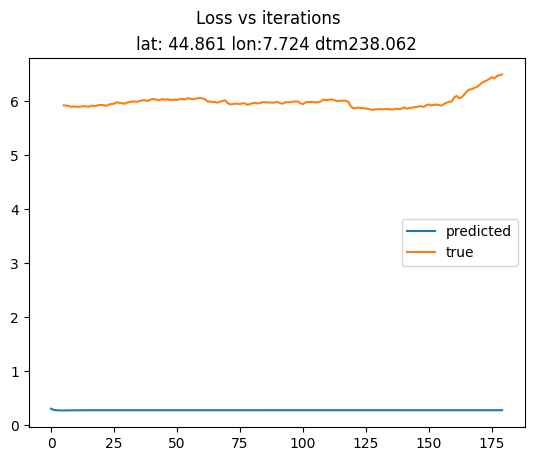

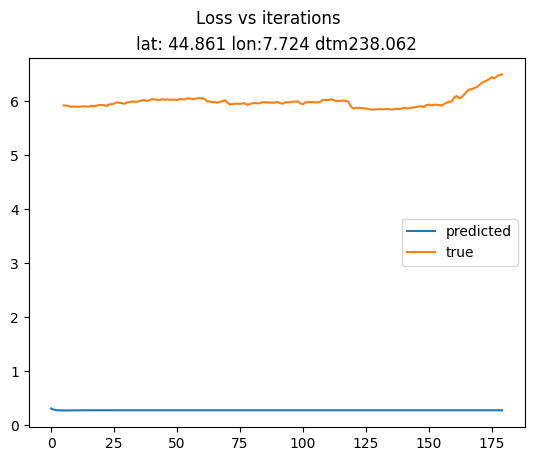

In [17]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

weather_coords = ds.get_weather_coords()
weather_dtm = ds.get_weather_dtm()
weather_coords = torch.cat([weather_coords, weather_dtm], dim = -1)

print('mem allocated in MB: ', torch.cuda.memory_allocated() / 1024**2)
#print(torch.cuda.memory_summary(device=None, abbreviated=False))

for i in range(max_epochs):
    
    model.train(True)
    start_time = time.time()
    print(f"############### Training epoch {i} ###############")
    
    with tqdm(train_loader, unit="batch") as tepoch:
            for batch_idx, (x, z, w_values, y, x_mask, y_mask) in enumerate(tepoch):
                tepoch.set_description(f"Epoch {i}")
                
                x = x.to(device)
                x_mask = x_mask.to(device)
                z = z.to(device)
                weather_coords_batch = weather_coords.unsqueeze(0).expand(w_values.shape[0], -1, -1, -1)
                w = [w_values.to(device), weather_coords_batch.to(device)]
                y = y.to(device)
                y_mask = y_mask.to(device)
                #print('Batch mem allocated in MB: ', torch.cuda.memory_allocated() / 1024**2)
                
                optimizer.zero_grad()
                
                y_hat = model(x, z, w, x_mask)
                #print('After predict mem allocated in MB: ', torch.cuda.memory_allocated() / 1024**2)
                loss = masked_mse(y_hat,
                                  y,
                                  y_mask)
                
                print(f"Train loss: {loss}")
                
                loss.backward()
                optimizer.step()
                
                metrics = {
                    "train_loss" : loss
                }
                wandb.log(metrics) 
                
                if batch_idx == 1:
                    break             
                
    end_time = time.time()
    exec_time = end_time-start_time

    wandb.log({"tr_epoch_exec_t" : exec_time})
    # Log the plot
    lat_plot = round(float(z[-1,0].detach().cpu()), 4)
    lon_plot = round(float(z[-1,1].detach().cpu()), 4)
    dtm_plot = round(float(z[-1,2].detach().cpu()))
    wandb.log({"training_pred":wandb.Image(plot_predictions(np.arange(0,dict_files["timesteps"]),
                                                 y[-1,:].detach().cpu(), y_hat[-1,:].detach().cpu(),
                                        title = f"lat: {lat_plot} lon:{lon_plot} dtm:{dtm_plot}"))
               })

    model_name = 'model_{}_{}.pt'.format(timestamp, i)    
    model_dir = dict_files["save_model_dir"]
    torch.save(model.state_dict(), f"{model_dir}/{model_name}") 

    print(f"############### Test epoch {i} ###############")
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    start_time = time.time()
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        with tqdm(test_loader, unit="batch") as tepoch:
                for batch_idx, (x, z, w_values, y, x_mask, y_mask) in enumerate(tepoch):
                    tepoch.set_description(f"Epoch {i}")

                    x = x.to(device)
                    x_mask = x_mask.to(device)
                    z = z.to(device)
                    weather_coords_batch = weather_coords.unsqueeze(0).expand(w_values.shape[0], -1, -1, -1)
                    w = [w_values.to(device), weather_coords_batch.to(device)]
                    y = y.to(device)
                    y_mask = y_mask.to(device)
                    # print('Batch mem allocated in MB: ', torch.cuda.memory_allocated() / 1024**2)

                    y_hat = model(x, z, w, x_mask)
                    # print('After predict mem allocated in MB: ', torch.cuda.memory_allocated() / 1024**2)

                    loss = masked_mse(y_hat,
                                  y,
                                  y_mask)
                    print(f"Test loss: {loss}")

                    metrics = {
                        "test_loss" : loss
                    }

                    wandb.log(metrics)
                    
                    if batch_idx == 1:
                        break  
        
    end_time = time.time()
    exec_time = end_time-start_time
    wandb.log({"test_epoch_exec_t" : exec_time})
    # Log the plot
    lat_plot = round(float(z[-1,0].detach().cpu()), 4)
    lon_plot = round(float(z[-1,1].detach().cpu()), 4)
    dtm_plot = round(float(z[-1,2].detach().cpu()))
    wandb.log({"test_pred": wandb.Image(plot_predictions(np.arange(0,dict_files["timesteps"]), y[-1,:].detach().cpu(), y_hat[-1,:].detach().cpu(),
                                        title = f"lat: {lat_plot} lon:{lon_plot} dtm:{dtm_plot}"))
               })


wandb.finish()

print(f"Execution time: {end_time-start_time}s")

# Test plots

In [7]:
batch_size = dict_files["batch_size"]
max_epochs = dict_files["epochs"]

test_split_p = dict_files["test_split_p"]
train_split_p = 1 - test_split_p

max_ds_elems = ds.__len__()
if not dict_files["all_dataset"]:
    max_ds_elems = dict_files["max_ds_elems"]

train_idx = int(max_ds_elems*train_split_p)
test_idx = int(max_ds_elems*test_split_p)
offset_idx = 100000

print(f"Traing size: {train_idx}, Test size: {test_idx}")

train_idxs, test_idxs = np.arange(offset_idx+train_idx), np.arange(offset_idx + train_idx,
                                                                   offset_idx + train_idx + test_idx)

train_sampler = RandomSampler(train_idxs)
test_sampler = SequentialSampler(test_idxs)

train_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=batch_size,
                                            sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=batch_size,
                                            sampler=test_sampler)

Traing size: 80000, Test size: 20000


In [8]:
model_path = "/leonardo_scratch/fast/IscrC_DL4EO/results/continuous_1d/models/model_20241227_111827.pt"

model = Continuous1DNN().to(device)
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
model.eval()

Continuous1DNN(
  (wgamma): Sigmoid()
  (cb_fc): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=16, bias=True)
    (7): ReLU()
  )
  (weather_wgamma): Sigmoid()
  (conv3d_stack): Sequential(
    (0): Conv3d(10, 16, kernel_size=(1, 2, 2), stride=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv3d(16, 16, kernel_size=(1, 2, 2), stride=(1, 1, 1))
    (4): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv3d(16, 16, kernel_size=(1, 2, 2), stride=(1, 1, 1))
    (7): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv3d(16, 16, kernel_size=(1, 2, 2), stride=(1, 1, 1

In [9]:
def masked_mse(y_hat, y, mask):
    return torch.sum(((y_hat[mask]-y[mask]))**2.0)  / torch.sum(mask)

def masked_mae(y_hat, y, mask):
    return torch.sum(torch.abs((y_hat[mask]-y[mask])))  / torch.sum(mask)

In [10]:
weather_coords = ds.get_weather_coords()
weather_dtm = ds.get_weather_dtm()
weather_coords = torch.cat([weather_coords, weather_dtm], dim = -1)

y_list = []
y_hat_list = []
mse_list = []
mae_list = []

with tqdm(test_loader, unit="batch") as tepoch:
                for batch_idx, (x, z, w_values, y, x_mask, y_mask) in enumerate(tepoch):
                    #tepoch.set_description(f"Epoch {i}")

                    x = x.to(device)
                    x_mask = x_mask.to(device)
                    z = z.to(device)
                    weather_coords_batch = weather_coords.unsqueeze(0).expand(w_values.shape[0], -1, -1, -1)
                    w = [w_values.to(device), weather_coords_batch.to(device)]
                    y = y.to(device)
                    y_mask = y_mask.to(device)
                    
                    y_hat = model(x, z, w, x_mask)
                    # denormalize 
                    y_hat = (y_hat * ds.wtd_std) + ds.wtd_mean
                    y = (y * ds.wtd_std) + ds.wtd_mean
                    
                    y_list.append(y)
                    y_hat_list.append(y_hat)

                    mse = masked_mse(y_hat,
                                  y,
                                  y_mask)
                    mse_list.append(mse)
                    
                    mae = masked_mae(y_hat,
                                  y,
                                  y_mask)
                    mae_list.append(mae)
                    
                    if batch_idx == 1:
                        break

  2%|▎         | 1/40 [01:03<41:11, 63.36s/batch]


In [44]:
sample_day = 20

In [35]:
#ds.wtd_names["munic"].loc[ds.wtd_names["sensor_id"] == ds.wtd_df["sensor_id"].loc[:, ds[0][1][0], ds[0][1][1]]]

IndexError: index 620 is out of bounds for dimension 0 with size 512

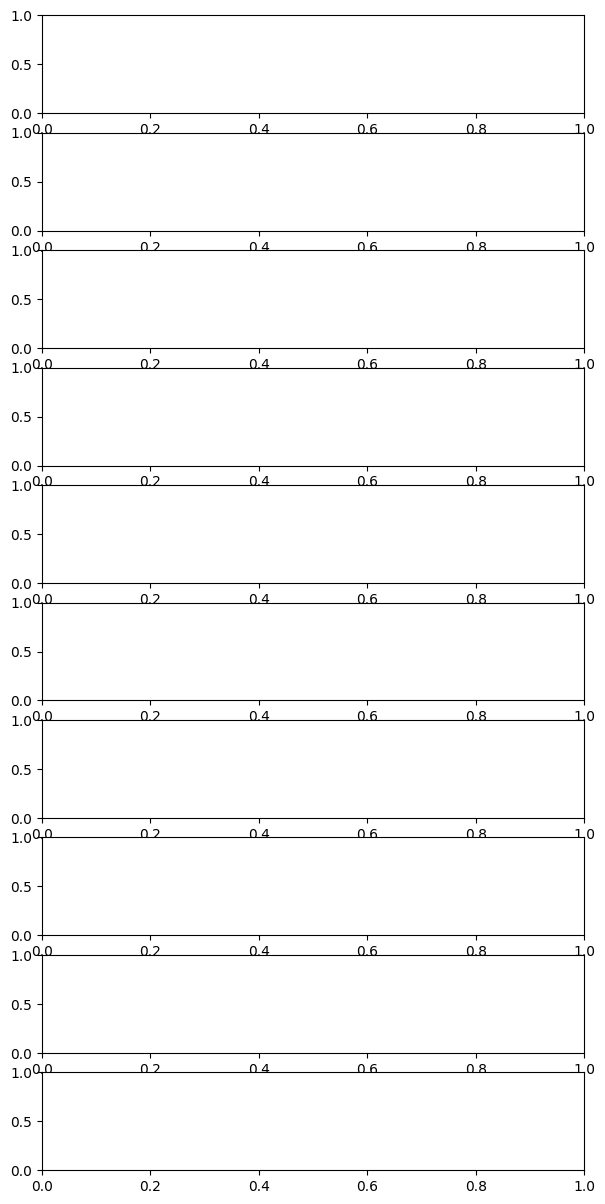

In [45]:
fig, ax = plt.subplots(10, figsize = (7,15))
for i in range(10):
        ax[i].plot(np.arange(180), y_list[0][(sample_day * 31) + i, :].detach().numpy(), label = "True")
        ax[i].plot(np.arange(180), y_hat_list[0][(sample_day * 31) + i, :].detach().numpy(), label = "Predicted")
        ax[i].legend()

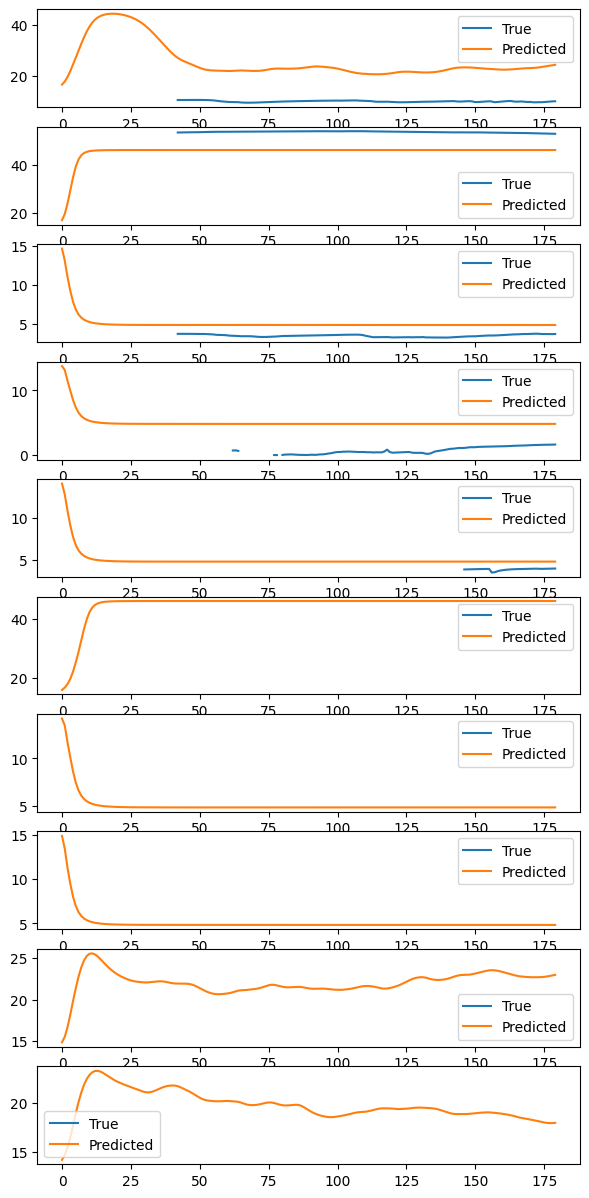

In [42]:
fig, ax = plt.subplots(10, figsize = (7,15))
for i in range(10,20):
        ax[i-10].plot(np.arange(180), y_list[0][(sample_day * 31) + i, :].detach().numpy(), label = "True")
        ax[i-10].plot(np.arange(180), y_hat_list[0][(sample_day * 31) + i, :].detach().numpy(), label = "Predicted")
        ax[i-10].legend()

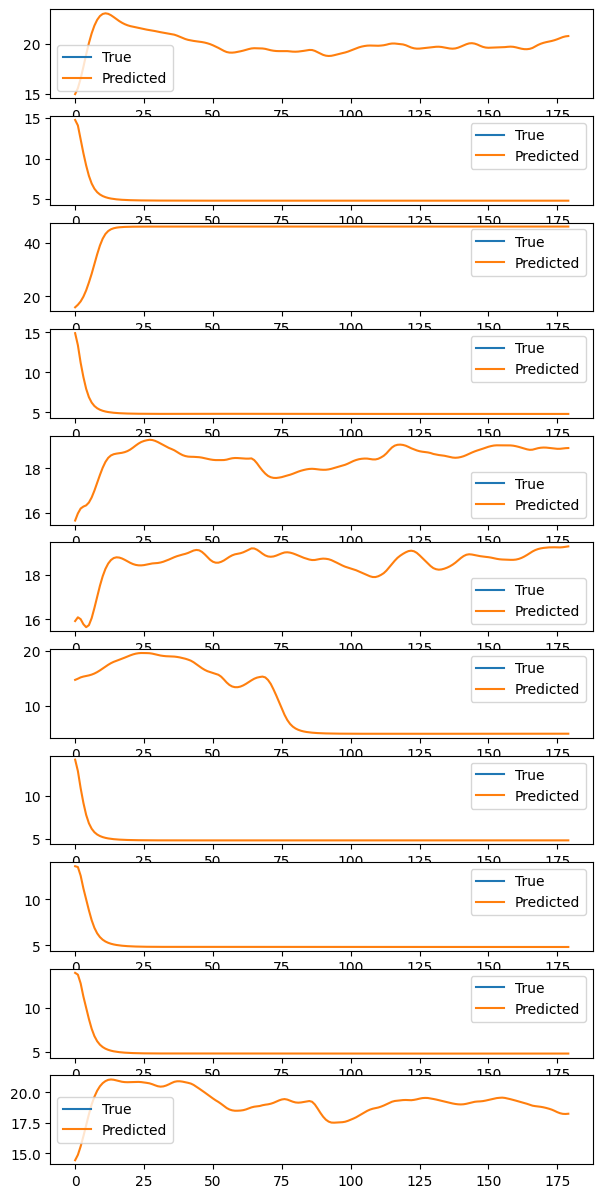

In [43]:
fig, ax = plt.subplots(11, figsize = (7,15))
for i in range(20,31):
        ax[i-20].plot(np.arange(180), y_list[0][(sample_day * 31) + i, :].detach().numpy(), label = "True")
        ax[i-20].plot(np.arange(180), y_hat_list[0][(sample_day * 31) + i, :].detach().numpy(), label = "Predicted")
        ax[i-20].legend()

In [ ]:
MAE = nn.L1Loss()
MSE = nn.MSELoss()

# Compute MAE
output_tensor = MAE(test_prediction, test_target)

# Compute RMSE
RMSE = MSE(test_prediction, test_target)
RMSE = torch.sqrt(RMSE)

print("MAE: ", MAE)
print("RSME: ", RMSE)